In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Read data

In [50]:
data = pd.read_csv(r'reaction_times.csv')
data.iloc[:, -4:] = np.nan

colList = data.columns.values

In [ ]:
for _idx, row in data.iterrows():
    congruent_vals_list  = []
    incongruent_vals_list = []
    
    congruent_accScores_list   = []
    incongruent_accScores_list = []

    #* itterating over reaction time recordings with obs_colIndex (shared accross column indices)
    for obs_colIndex in range(1, 21):
        #* Congruent data branch
        if row[f"trial_type{obs_colIndex}"] == True and row[f"accuracy{obs_colIndex}"] == "Correct":
            congruent_vals_list.append(row[f"rt{obs_colIndex}"])
            congruent_accScores_list.append(1)

        #* Incongruent data branch
        elif row[f"trial_type{obs_colIndex}"] == False and row[f"accuracy{obs_colIndex}"] == "Correct":
            incongruent_vals_list.append(row[f"rt{obs_colIndex}"])
            incongruent_accScores_list.append(1)

    
    data.loc[_idx, 'avg_incongruent'] = np.mean(incongruent_vals_list) if incongruent_vals_list else 0.0
    data.loc[_idx, 'acc_incongruent'] = np.sum(incongruent_accScores_list)/20
    data.loc[_idx, 'avg_congruent'] = np.mean(congruent_vals_list) if congruent_vals_list else 0.0
    data.loc[_idx, 'acc_congruent'] = np.sum(congruent_accScores_list)/20

## Split into control and exercise group

In [63]:
print(f"Before outlier remova {data.shape}")
# data = data[data["avg_incongruent"] <= 2.5] #removing high rt values
print(f"After outlier remova {data.shape}")

data_exercise = data[(data["group"] == "exercise") & (data["avg_incongruent"] != 0.0)]
data_control = data[(data["group"] == "control") & (data["avg_incongruent"] != 0.0)]

exercise_tr1 = data_exercise[data_exercise["trial"] == 1]
exercise_tr2 = data_exercise[data_exercise["trial"] == 2]

control_tr1 = data_control[data_control["trial"] == 1]
control_tr2 = data_control[data_control["trial"] == 2]

print(len(data_exercise["id"].unique()))
print(len(data_control["id"].unique()))
print(len(data_exercise["id"].unique()) + len(data_control["id"].unique()))
# data.to_csv("rt_data_with_computed_averages.csv", index= False)

Before outlier remova (86, 70)
After outlier remova (86, 70)
24
19
43


In [59]:
exp_df_incongruent_accurate = pd.DataFrame(columns= ['id', 'trial', 'gender', 'group', 'age', 'time','rt', 'trial_type'])

rows_to_append = []
for _idx, row in data.iterrows():
    for i in range(1,21):
        if row[f"accuracy{i}"] == "Correct" and row[f"trial_type{i}"] == False:
            dict_df = {'id'     : row["id"] , 
                       'trial'  : row["trial"], 
                       'gender' : row["gender"], 
                       'group'  : row["group"], 
                       'age'    : row["age"], 
                       'time'   : row["time"],
                       'rt'     : row[f"rt{i}"], 
                       'trial_type' : "Incongruent" }
            rows_to_append.append(dict_df)
exp_df_incongruent_accurate = pd.DataFrame(rows_to_append)
# exp_df_incongruent_accurate.to_csv("expanded_rt_incon_accurate.csv", index= False)

### *Plot **1stTrial** vs **2ndTrial** differences in <span style="color:darkred">Congruent</span> observations*

In [ ]:
congruent_exercise_averages = [np.mean(exercise_tr1["avg_congruent"]), np.mean(exercise_tr2["avg_congruent"])]                            
congruent_control_averages = [np.mean(control_tr1["avg_congruent"]), np.mean(control_tr2["avg_congruent"])]

plt.plot([1, 2], congruent_exercise_averages, marker='o')
plt.plot([1, 2], congruent_control_averages, marker='o')
plot_data = pd.DataFrame({
    'trial': [1, 2, 1, 2],
    'reaction_time': congruent_exercise_averages + congruent_control_averages,
    'group': ['exercise', 'exercise', 'control', 'control']
})
#add labels 
sns.scatterplot(data=plot_data, x='trial', y='reaction_time', hue='group')
plt.xlabel('Trial')
plt.xticks([1, 2])
plt.ylabel('Reaction time (s)')
plt.title('Reaction time Congruent by group and trial')

### *Plot **1stTrial** vs **2ndTrial** differences in <span style="color:darkred">Incongruent</span> observations*

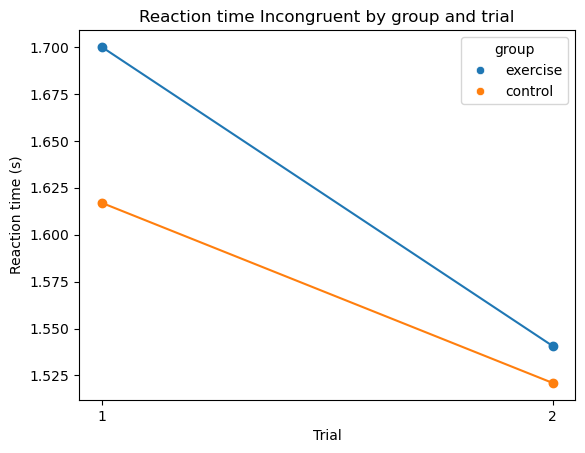

In [77]:
incongruent_exercise_averages = [np.mean(exercise_tr1["avg_incongruent"]), np.mean(exercise_tr2["avg_incongruent"])]                            
incongruent_control_averages = [np.mean(control_tr1["avg_incongruent"]), np.mean(control_tr2["avg_incongruent"])]

plt.plot([1, 2], incongruent_exercise_averages, marker='o')
plt.plot([1, 2], incongruent_control_averages, marker='o')
plot_data = pd.DataFrame({
    'trial': [1, 2, 1, 2],
    'reaction_time': incongruent_exercise_averages + incongruent_control_averages,
    'group': ['exercise', 'exercise', 'control', 'control']
})
#add labels 
sns.scatterplot(data=plot_data, x='trial', y='reaction_time', hue='group')
plt.xlabel('Trial')
plt.xticks([1, 2])
plt.ylabel('Reaction time (s)')
plt.title('Reaction time Incongruent by group and trial')

output_path = r"Plots/lines_very_high_view.png"  # Replace with your desired path
plt.savefig(output_path, format='png', dpi=300) 

### *Plot **1stTrial** vs **2ndTrial** differences in <span style="color:darkred">Overall</span> observations*

In [ ]:
exercise_averages = [np.mean( [np.mean(exercise_tr1["avg_congruent"]), np.mean(exercise_tr1["avg_incongruent"])] ), \
                     np.mean( [np.mean(exercise_tr2["avg_congruent"]), np.mean(exercise_tr2["avg_incongruent"])] )]                        
control_averages = [np.mean( [np.mean(control_tr1["avg_congruent"]), np.mean(control_tr1["avg_incongruent"])] ), \
                     np.mean( [np.mean(control_tr2["avg_congruent"]), np.mean(control_tr2["avg_incongruent"])] )]   

plt.plot([1, 2], exercise_averages, marker='o')
plt.plot([1, 2], control_averages, marker='o')
plot_data = pd.DataFrame({
    'trial': [1, 2, 1, 2],
    'reaction_time': exercise_averages + control_averages,
    'group': ['exercise', 'exercise', 'control', 'control']
})
#add labels 
sns.scatterplot(data=plot_data, x='trial', y='reaction_time', hue='group')
plt.xlabel('Trial')
plt.xticks([1, 2])
plt.ylabel('Reaction time (s)')
plt.title('Reaction time Overall by group and trial')

# box plot

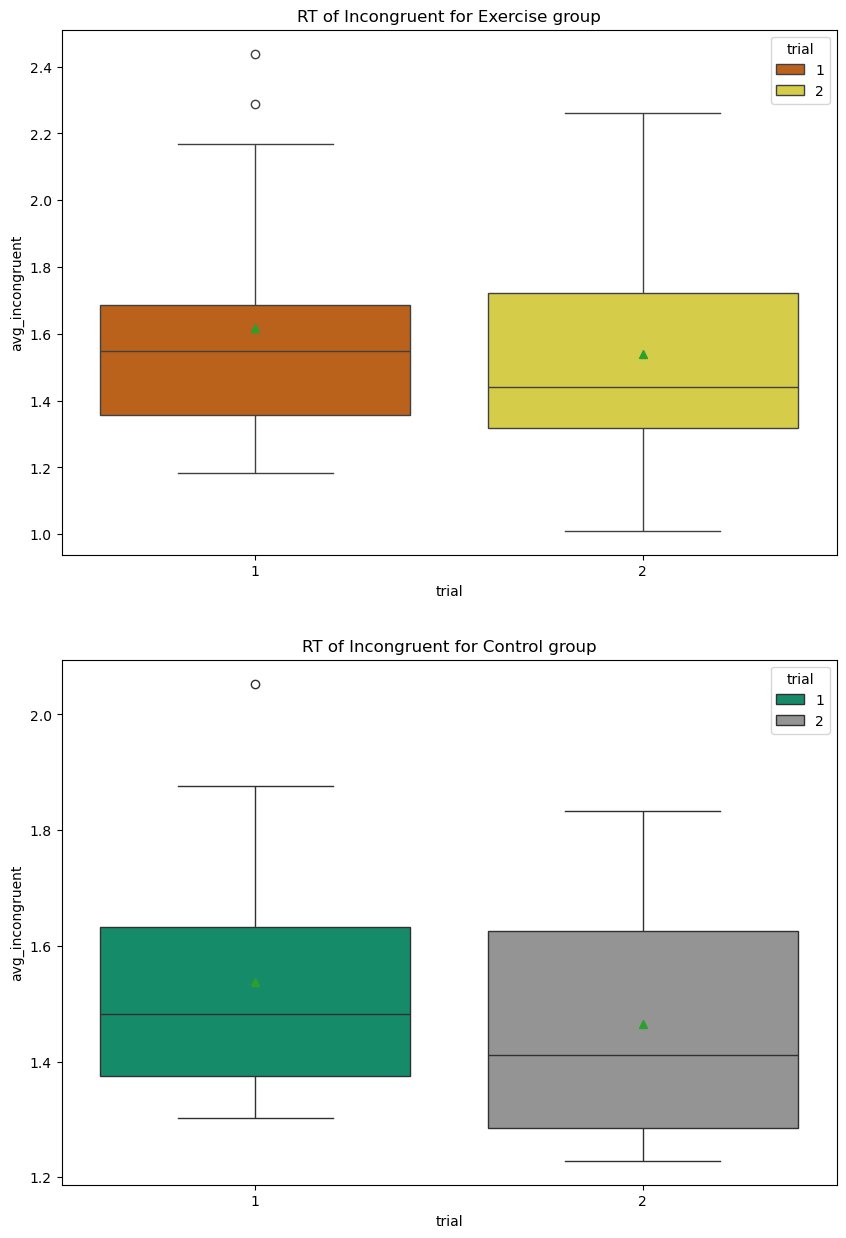

In [9]:
colorblind_palette = sns.color_palette("colorblind")
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

sns.boxplot(x="trial", y="avg_incongruent", data=data_exercise, ax=ax[0], hue='trial', palette=[colorblind_palette[3], colorblind_palette[8]], legend=True, showmeans=True)
ax[0].set_title("RT of Incongruent for Exercise group")

sns.boxplot(x="trial", y="avg_incongruent", data=data_control, ax=ax[1], hue='trial', palette=[colorblind_palette[2], colorblind_palette[7]], legend=True, showmeans=True)
ax[1].set_title("RT of Incongruent for Control group")

plt.show()

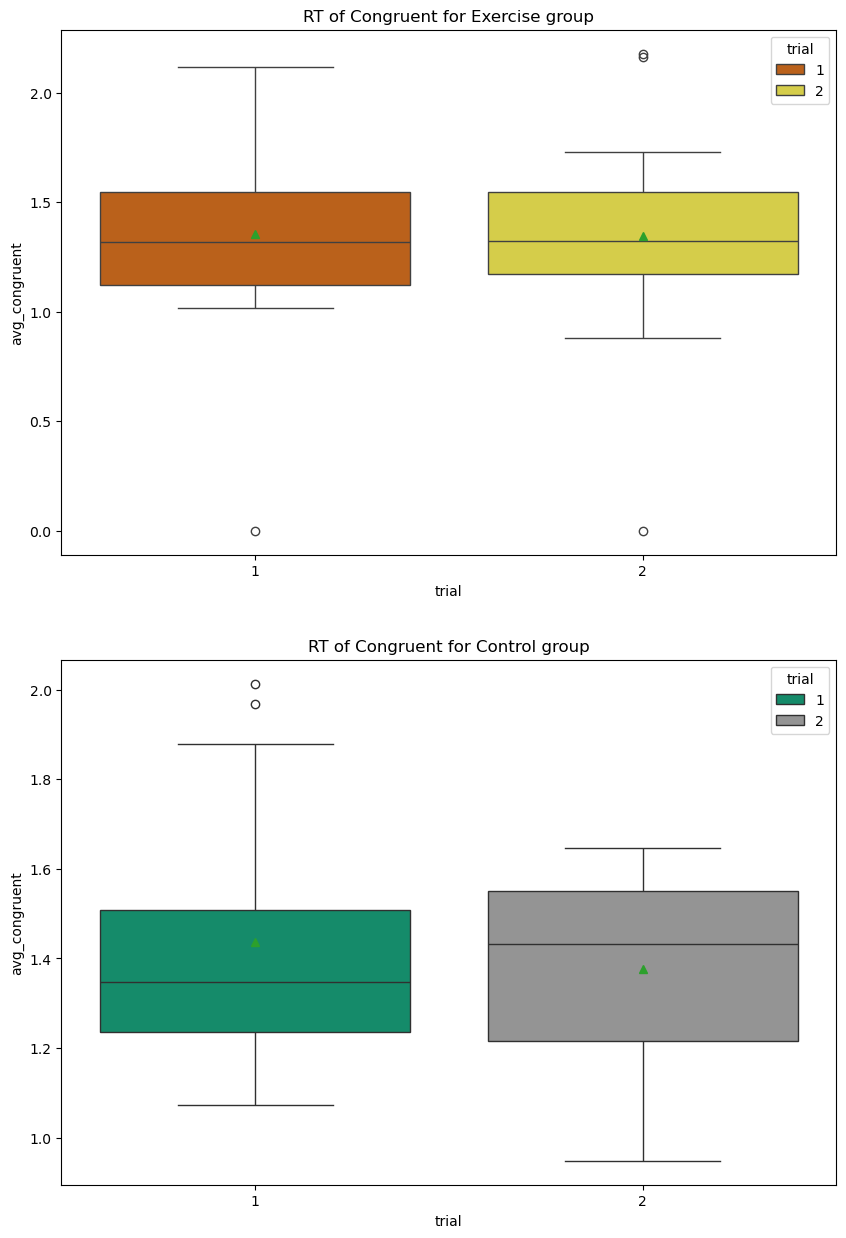

In [10]:
colorblind_palette = sns.color_palette("colorblind")
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

sns.boxplot(x="trial", y="avg_congruent", data=data_exercise, ax=ax[0], hue='trial', palette=[colorblind_palette[3], colorblind_palette[8]], legend=True, showmeans=True)
ax[0].set_title("RT of Congruent for Exercise group")

sns.boxplot(x="trial", y="avg_congruent", data=data_control, ax=ax[1], hue='trial', palette=[colorblind_palette[2], colorblind_palette[7]], legend=True, showmeans=True)
ax[1].set_title("RT of Congruent for Control group")

plt.show()

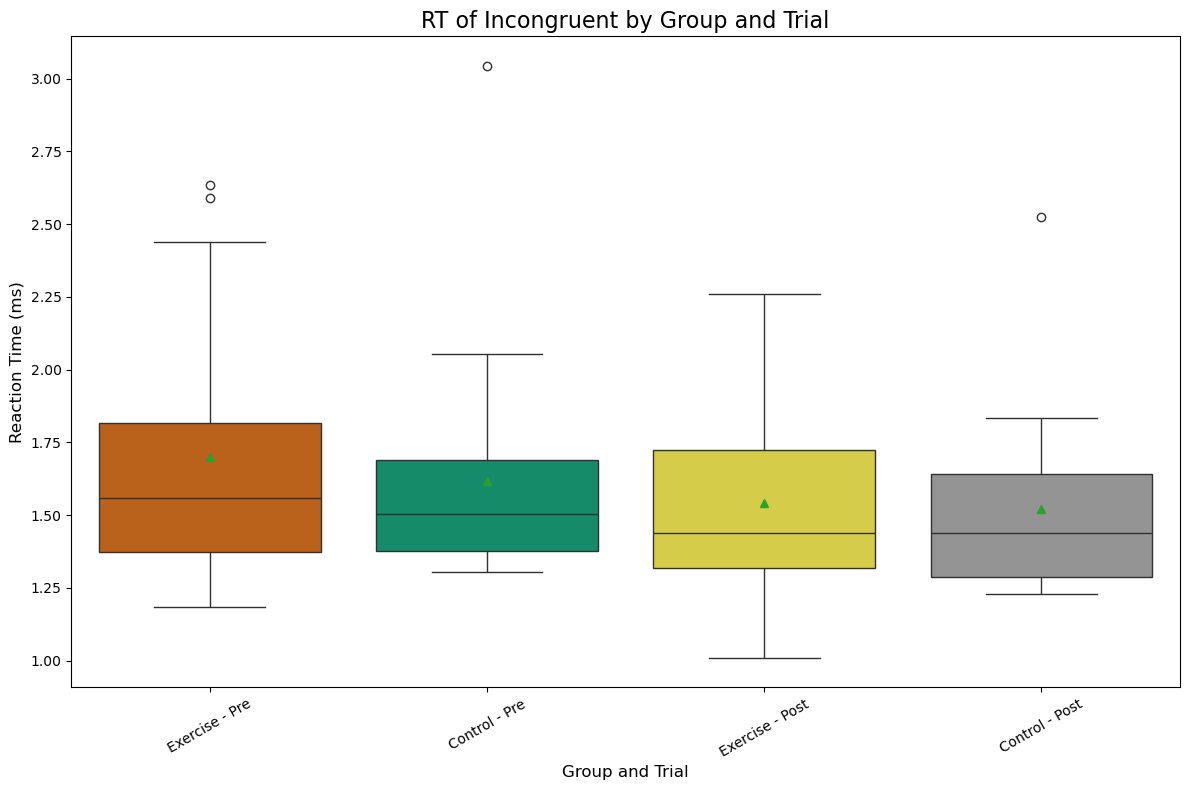

In [78]:
colorblind_palette = sns.color_palette("colorblind")

# Create a single subplot for all four boxplots
fig, ax = plt.subplots(figsize=(12, 8))

# Combine exercise and control groups for Trial 1 and Trial 2 into one DataFrame
plot_data = pd.concat([
    data_exercise[data_exercise["trial"] == 1].assign(trial_group="Exercise - Pre"),
    data_control[data_control["trial"] == 1].assign(trial_group="Control - Pre"),
    data_exercise[data_exercise["trial"] == 2].assign(trial_group="Exercise - Post"),
    data_control[data_control["trial"] == 2].assign(trial_group="Control - Post")
])

# Define colors for the four groups
box_colors = [colorblind_palette[3],  # Orange for Exercise - Trial 1
              colorblind_palette[2],  # Green for Control - Trial 1
              colorblind_palette[8],  # Yellow for Exercise - Trial 2
              colorblind_palette[7]]  # Gray for Control - Trial 2


# hue_list = ["Exercise - Pre", "Control - Pre", "Exercise - Post", "Control - Post"]
sns.boxplot(x="trial_group", y="avg_incongruent", hue= "trial_group", data=plot_data, palette=box_colors, showmeans=True, ax=ax)

# Customize the plot
ax.set_title("RT of Incongruent by Group and Trial", fontsize=16)
ax.set_xlabel("Group and Trial", fontsize=12)
ax.set_ylabel("Reaction Time (ms)", fontsize=12)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# Show the plot
plt.tight_layout()
# print([x.get_text() for x in list(ax.get_xticklabels())] )
output_path = r"Plots/boxPlots_very_high_view.png"  # Replace with your desired path
plt.savefig(output_path, format='png', dpi=300) 

plt.show()

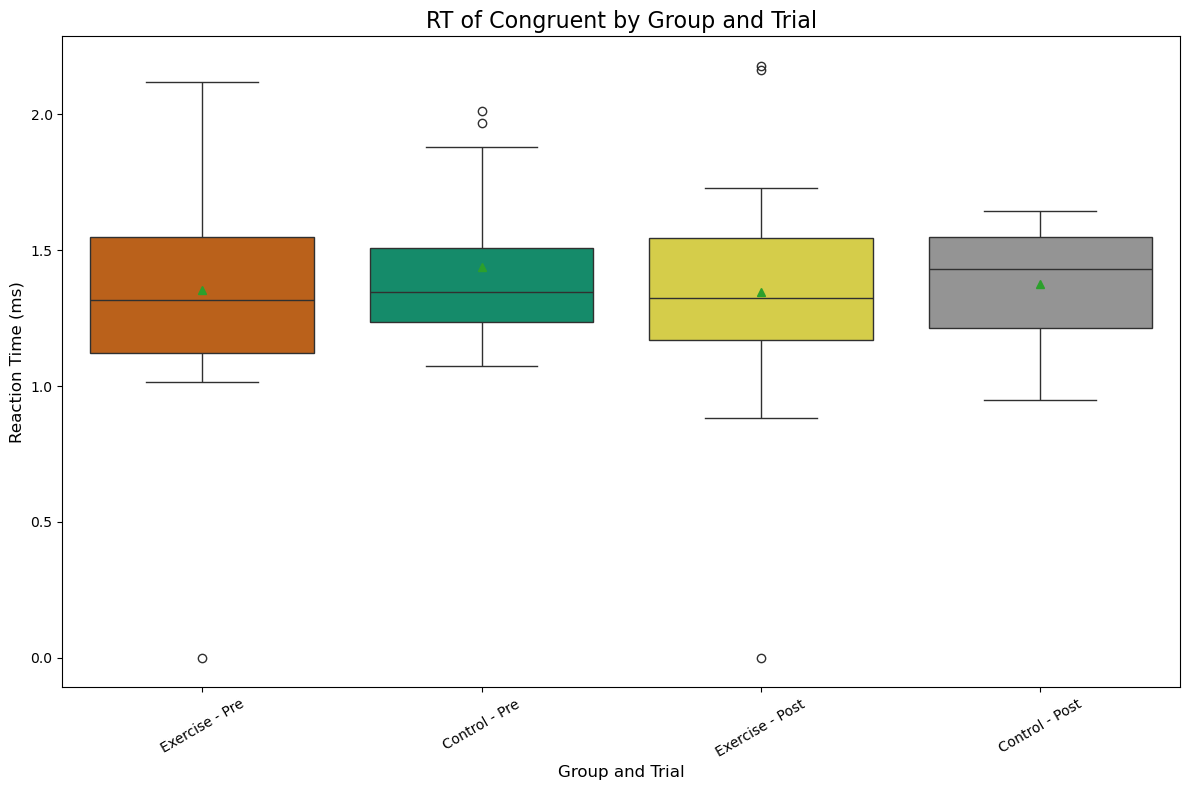

In [14]:
colorblind_palette = sns.color_palette("colorblind")

# Create a single subplot for all four boxplots
fig, ax = plt.subplots(figsize=(12, 8))

# Combine exercise and control groups for Trial 1 and Trial 2 into one DataFrame
plot_data = pd.concat([
    data_exercise[data_exercise["trial"] == 1].assign(trial_group="Exercise - Pre"),
    data_control[data_control["trial"] == 1].assign(trial_group="Control - Pre"),
    data_exercise[data_exercise["trial"] == 2].assign(trial_group="Exercise - Post"),
    data_control[data_control["trial"] == 2].assign(trial_group="Control - Post")
])

# Define colors for the four groups
box_colors = [colorblind_palette[3],  # Orange for Exercise - Trial 1
              colorblind_palette[2],  # Green for Control - Trial 1
              colorblind_palette[8],  # Yellow for Exercise - Trial 2
              colorblind_palette[7]]  # Gray for Control - Trial 2

# Plot all four boxplots on the same axis
sns.boxplot(x="trial_group", y="avg_congruent", hue= "trial_group", data=plot_data, palette=box_colors, showmeans=True, ax=ax)

# Customize the plot
ax.set_title("RT of Congruent by Group and Trial", fontsize=16)
ax.set_xlabel("Group and Trial", fontsize=12)
ax.set_ylabel("Reaction Time (ms)", fontsize=12)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# Show the plot
plt.tight_layout()
plt.show()


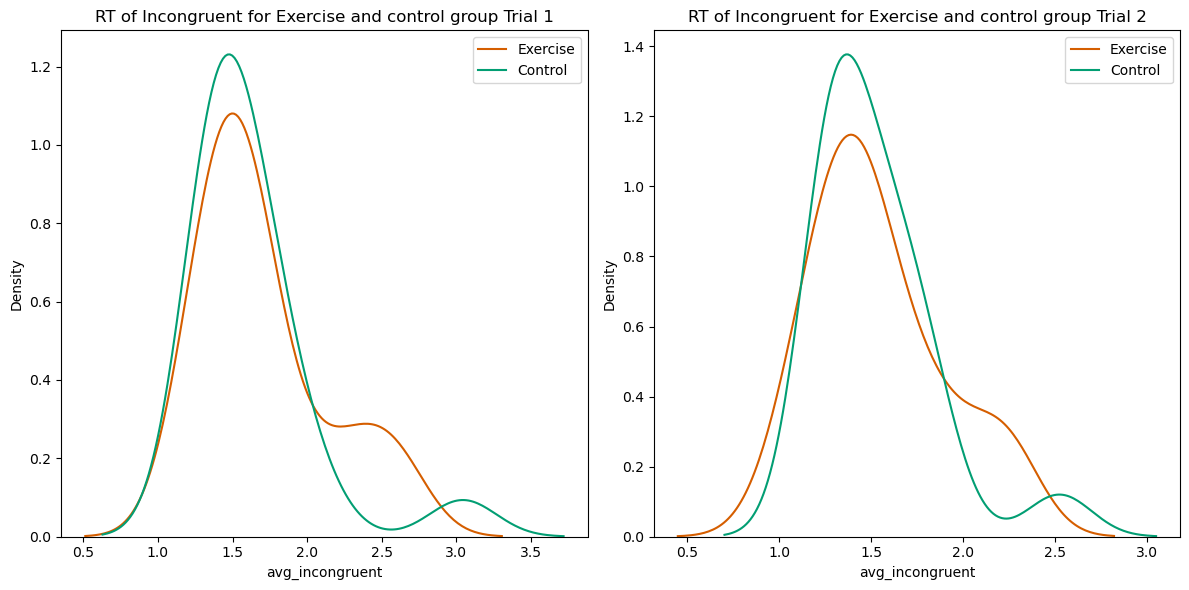

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# KDE plot for the 'avg_incongruent' column
sns.kdeplot(exercise_tr1["avg_incongruent"], ax=ax[0], color=colorblind_palette[3])
sns.kdeplot(control_tr1["avg_incongruent"], ax=ax[0], color=colorblind_palette[2])
ax[0].set_title("RT of Incongruent for Exercise and control group Trial 1")
ax[0].legend(["Exercise", "Control"])
# KDE plot for the 'avg_congruent' column
# sns.kdeplot(exercise_tr1["avg_congruent"], ax=ax[1], color=colorblind_palette[8])
# sns.kdeplot(control_tr1["avg_congruent"], ax=ax[1], color=colorblind_palette[7])
# ax[1].set_title("RT of Congruent for Exercise and control group Trial 1")
# ax[1].legend(["Exercise", "Control"])

# KDE plot for the 'avg_incongruent' column
sns.kdeplot(exercise_tr2["avg_incongruent"], ax=ax[1], color=colorblind_palette[3])
sns.kdeplot(control_tr2["avg_incongruent"], ax=ax[1], color=colorblind_palette[2])
ax[1].set_title("RT of Incongruent for Exercise and control group Trial 2")
ax[1].legend(["Exercise", "Control"])

# # KDE plot for the 'avg_congruent' column
# sns.kdeplot(exercise_tr2["avg_congruent"], ax=ax[1,1], color=colorblind_palette[8])
# sns.kdeplot(control_tr2["avg_congruent"], ax=ax[1,1], color=colorblind_palette[7])
# ax[1,1].set_title("RT of Congruent for Exercise and control group Trial 2")
# ax[1,1].legend(["Exercise", "Control"]) 


plt.tight_layout()

output_path = r"Plots/distribution_very_high_view.png"  # Replace with your desired path
plt.savefig(output_path, format='png', dpi=300) 
plt.show()

In [16]:
print(f"error rate for incon exercise 1 is  {1- exercise_tr1.acc_incongruent.mean()}")
print(f"error rate for incon control  1 is  {1- control_tr1.acc_incongruent.mean()}")
print(f"error rate for incon exercise 1 is  {1- exercise_tr2.acc_incongruent.mean()}")
print(f"error rate for incon control  1 is  {1- control_tr2.acc_incongruent.mean()}")

error rate for incon exercise 1 is  0.23409090909090924
error rate for incon control  1 is  0.1972222222222224
error rate for incon exercise 1 is  0.24791666666666667
error rate for incon control  1 is  0.2416666666666667


In [17]:
print(f"error rate for con exercise 1 is  {1- exercise_tr1.acc_congruent.mean()}")
print(f"error rate for con control 1 is   {1- control_tr1.acc_congruent.mean()}")
print(f"error rate for con exercise 1 is  {1- exercise_tr2.acc_congruent.mean()}")
print(f"error rate for con control  1 is  {1- control_tr2.acc_congruent.mean()}")

error rate for con exercise 1 is  0.7863636363636364
error rate for con control 1 is   0.8166666666666667
error rate for con exercise 1 is  0.7583333333333333
error rate for con control  1 is  0.7722222222222223


In [18]:
print(f"avg rt for incongruent exercise 1 is {exercise_tr1.avg_incongruent.mean()}")
print(f"avg rt for incongruent control 1 is  {control_tr1.avg_incongruent.mean()}")
print(f"avg rt for incongruent exercise 2 is {exercise_tr2.avg_incongruent.mean()}")
print(f"avg rt for incongruent control 2 is  {control_tr2.avg_incongruent.mean()}")

avg rt for incongruent exercise 1 is 1.6171851628498302
avg rt for incongruent control 1 is  1.5376970983551301
avg rt for incongruent exercise 2 is 1.5407066654405102
avg rt for incongruent control 2 is  1.4652475300782646


In [19]:
print(f"avg rt for congruent exercise 1 is {exercise_tr1.avg_congruent.mean()}")
print(f"avg rt for congruent control 1 is  {control_tr1.avg_congruent.mean()}")
print(f"avg rt for congruent exercise 2 is {exercise_tr2.avg_congruent.mean()}")
print(f"avg rt for congruent control 2 is  {control_tr2.avg_congruent.mean()}")

avg rt for congruent exercise 1 is 1.354329944125074
avg rt for congruent control 1 is  1.4374894496335688
avg rt for congruent exercise 2 is 1.3478590250002966
avg rt for congruent control 2 is  1.3765875632311546


In [20]:
print(data_exercise.shape)
print(data_exercise["acc_incongruent"].unique() == 0.0)
print(data_exercise["acc_congruent"].unique() == 0.0)
data_exercise = data_exercise[data_exercise["avg_congruent"] != 0.0]
print(data_exercise.shape)


print(data_control.shape)
print(data_control["acc_incongruent"].unique() == 0.0)
print(data_control["acc_congruent"].unique() == 0.0)
data_control = data_control[data_control["avg_congruent"] != 0.0]
print(data_control.shape)


(46, 70)
[False False False False False False False False False False False False
 False]
[False False False False False False False False False False  True False]
(44, 70)
(36, 70)
[False False False False False False False False False]
[False False False False False False False]
(36, 70)


# Testing normality of data

In [21]:
from scipy.stats import shapiro
print(shapiro(exercise_tr1.avg_incongruent))
print(shapiro(control_tr1.avg_incongruent))
print(shapiro(exercise_tr2.avg_incongruent)) # the only one that is normally distributed
print(shapiro(control_tr2.avg_incongruent))


ShapiroResult(statistic=0.8818839557052671, pvalue=0.013126519819873507)
ShapiroResult(statistic=0.9051972216857681, pvalue=0.07082771967796539)
ShapiroResult(statistic=0.9223261377720138, pvalue=0.06576354972160924)
ShapiroResult(statistic=0.8894198605590447, pvalue=0.03771960161279295)


In [22]:
from scipy.stats import shapiro
exercise_tr1 = exercise_tr1[exercise_tr1["avg_congruent"] != 0.0]
control_tr1  =  control_tr1[control_tr1["avg_congruent"] != 0.0]
exercise_tr2 = exercise_tr2[exercise_tr2["avg_congruent"] != 0.0]
control_tr2  =  control_tr2[control_tr2["avg_congruent"] != 0.0]
print(shapiro(exercise_tr1.avg_congruent))
print(shapiro(control_tr1.avg_congruent))
print(shapiro(exercise_tr2.avg_congruent)) 
print(shapiro(control_tr2.avg_congruent)) # the only one that is normally distributed

ShapiroResult(statistic=0.9249137146979682, pvalue=0.10883787477294632)
ShapiroResult(statistic=0.8600453738820015, pvalue=0.01224612162945409)
ShapiroResult(statistic=0.9331597097913038, pvalue=0.1279803160990826)
ShapiroResult(statistic=0.9186471719605872, pvalue=0.12233314282305852)


In [23]:
row_rt_list_exercise = []
row_rt_list_control = []
for _idx, row in data.iterrows():
    for i in range(1, 21):
        if row[f"accuracy{i}"] == "Correct" and row[f"trial_type{i}"] == False:
            if row["group"] == "exercise":
                row_rt_list_exercise.append(row[f"rt{i}"])
            if row["group"] == "control":
                row_rt_list_control.append(row[f"rt{i}"])
    # row_rt_list = [row[f"rt{i}"] if (row[f"accuracy{i}"] == "Correct" and row[f"trial_type{1}"] == False) for i in range(1,21)]
    
print(f"{len(row_rt_list_exercise)} ----> {shapiro(row_rt_list_exercise)}")
print(f"{len(row_rt_list_control)} ----> {shapiro(row_rt_list_control)}")

698 ----> ShapiroResult(statistic=0.9071725841813153, pvalue=3.411470993853022e-20)
562 ----> ShapiroResult(statistic=0.9294024953623659, pvalue=1.2984773289638882e-15)


## Linear mixed models

p value < 0.05, Data is not normally distributed.

In [24]:
control_total = control_1.shape[0]

exercise_1 = exercise_1.iloc[:control_total]
exercise_2 = exercise_2.iloc[:control_total]
#merge the data
data_balanced = pd.concat([exercise_1, control_1, exercise_2, control_2])


NameError: name 'control_1' is not defined

In [ ]:
df = data[["id", "group", "trial", "avg_incongruent"]]

model = smf.mixedlm("avg_incongruent ~ trial * group", df, groups=df["id"]).fit()

print(model.summary())

In [ ]:
df = data[["id", "group", "trial", "avg_incongruent", "avg_congruent", "gender", "age", "time"]]

df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

df['hour'] = df['time'].dt.hour

# seperate the time into morning, afternoon, night
def categorize_time(hour):
    if 8 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(categorize_time)

# Fit the MLM model with trial, group, and their interaction as fixed effects, plus gender, age as covariates
model_mlm = smf.mixedlm("avg_incongruent ~ trial * group + gender + age + time_of_day", 
                         df, 
                         groups=df["id"]).fit()

# Print the MLM model summary
print(model_mlm.summary())

Significant Effect of Trial. No Significant Group Differences. Non-significant Effects of Gender and Age and Time. No Significant Interaction Between Trial and Group. Random Effects: The random effect variance (Group Var) is suggesting there is some variability between participants.

In [ ]:
df['group'] = df['group'].astype('category')
df['gender'] = df['gender'].astype('category')

# Define time categories (morning, afternoon, night)
def categorize_time(hour):
    if 8 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    else:
        return 'night'

# Apply time categorization
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')
df['hour'] = df['time'].dt.hour
df['time_of_day'] = df['hour'].apply(categorize_time)

# Clean the data (removing NaNs in 'avg_congruent')
df_clean = df.dropna(subset=["avg_congruent"])

# Explicitly convert 'time_of_day' to categorical
df_clean['time_of_day'] = df_clean['time_of_day'].astype('category')

# Fit the mixed-effects model
model_mlmc = smf.mixedlm("avg_congruent ~ trial * group + gender + age + time_of_day", 
                         df_clean, 
                         groups=df_clean["id"]).fit()

# Print the summary
print(model_mlmc.summary())

Lack of data in congruent part, it shows gender and age affect most.

In [ ]:
# Separate data by group
exercise_group = data[data['group'] == 'exercise']
control_group = data[data['group'] == 'control']

# Separate data by trial within each group
exercise_1 = exercise_group[exercise_group['trial'] == 1]  # trial 1 for exercise group
exercise_2 = exercise_group[exercise_group['trial'] == 2]  # trial 2 for exercise group
control_1 = control_group[control_group['trial'] == 1]  # trial 1 for control group
control_2 = control_group[control_group['trial'] == 2]  # trial 2 for control group

# --- 1. Mann-Whitney U Test (between-group comparisons) ---
# Compare the 'avg_incongruent' between exercise and control groups for trial 1 (pre-exercise)
stat, p_value = mannwhitneyu(exercise_1['avg_incongruent'], control_1['avg_incongruent'])
print(f"Mann-Whitney U Test (Exercise vs Control - Trial 1):")
print(f"Statistic: {stat}, p-value: {p_value}\n")

# Compare the 'avg_incongruent' between exercise and control groups for trial 2 (post-exercise)
stat, p_value = mannwhitneyu(exercise_2['avg_incongruent'], control_2['avg_incongruent'])
print(f"Mann-Whitney U Test (Exercise vs Control - Trial 2):")
print(f"Statistic: {stat}, p-value: {p_value}\n")

# --- 2. Wilcoxon Signed-Rank Test (within-subject comparisons) ---
# Compare within the exercise group (trial 1 vs trial 2)
stat, p_value = wilcoxon(exercise_1['avg_incongruent'], exercise_2['avg_incongruent'])
print(f"Wilcoxon Signed-Rank Test (Exercise - Trial 1 vs Trial 2):")
print(f"Statistic: {stat}, p-value: {p_value}\n")

# Compare within the control group (trial 1 vs trial 2)
stat, p_value = wilcoxon(control_1['avg_incongruent'], control_2['avg_incongruent'])
print(f"Wilcoxon Signed-Rank Test (Control - Trial 1 vs Trial 2):")
print(f"Statistic: {stat}, p-value: {p_value}\n")


The Mann-Whitney U Tests show no significant between-group differences in reaction times for both trials.
The Wilcoxon Signed-Rank Tests show significant within-group changes, indicating that both the exercise group and the control group exhibit significant differences in reaction times between trials.

In [ ]:
from statsmodels.stats.power import FTestAnovaPower

# Assume the effect size is 0.02 (small effect), significance level is 0.05, and statistical power is 0.8
effect_size = 0.1  # Cohen’s f² value 
alpha = 0.05  # Significance level (commonly set to 0.05)
power = 0.80  # Statistical power (commonly set to 0.80)

# Create an object for power analysis (ANOVA F-test)
anova_power = FTestAnovaPower()

# Estimate the required sample size (assuming 1 fixed effects and 2 groups for comparison)
# Here, we are calculating the required sample size for ANOVA (for a mixed-effects model, the sample size estimation would require different methods)
required_sample_size = anova_power.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=2)  # k_groups indicates the number of groups in the comparison

# Print the required sample size, rounded up to the nearest integer
print(f"Required sample size: {np.ceil(required_sample_size)}")


